**Note: This simulation code and its explanation were generated by Gemini, a large language model from Google. It is an educational model designed to simplify and explain the complex behavior of Linux memory management and does not represent the full implementation of the actual kernel.**

### **Simulation Premise**

This simulation models and simplifies several key concepts of the complex memory management behavior in the Linux kernel to make it easier to understand.

#### **1\. Key Concepts Modeled**

* **Anonymous Pages (NR\_ANON\_MAPPED)**: This is the memory area for a process's heap and stack, which is not associated with a specific file. In this simulation, memory acquisition by a process is treated as an **increase in anonymous pages**, shown as a magenta line on the graph.  
* **Page Cache (NR\_FILE\_PAGES)**: This is the area in RAM that temporarily holds the contents of files from the disk. This simulation assumes that a certain amount of page cache exists in the initial state.  
* **swappiness**: A parameter (value 0-100) that determines the priority between **discarding the page cache** and **swapping out anonymous pages** when memory is low.  
* **Watermarks (min, low, high)**:
  * **high**: This watermark is the goal for background reclamation; `kswapd` will stop freeing pages once the amount of free memory reaches this level.
  * **low**: When free memory falls below this watermark, the `kswapd` kernel thread is awakened to start reclaiming pages asynchronously in the background.
  * **min**: If free memory drops below this critical watermark, a process requesting memory must perform synchronous page reclaiming ("direct reclaim"), pausing its own execution until pages are freed.
* **Page Reclaim Mechanisms**:  
  * **kswapd / Direct Reclaim**: When memory is scarce, these mechanisms are activated. After determining the total number of pages to reclaim, they decide what proportion to reclaim from the page cache versus anonymous pages based on the swappiness value.  
* **OOM (Out of Memory) Killer**: The last resort, invoked at the moment it is determined that the min\_wmark cannot be maintained even after attempting all available page reclaim methods (discarding page cache and swapping out). It terminates a process to prevent the entire system from halting.

#### **2\. Simplifications and Omissions**

* **Reclaim Efficiency**: The amount of pages reclaimed or swapped out is assumed to be constant.  
* **Swap-in**: The behavior of reading data back from swap into RAM ("swap-in") is not modeled.  
* **Dirty Pages**: The concept of "dirty pages" within the page cache, which require writing back to disk, is omitted.

### **Scenario Explanations**

#### **Scenario 1: High Load → OOM-Kill (swappiness=60)**

This scenario shows the behavior when the system is under a high load that exceeds its memory allocation capabilities.

1. **Memory Pressure**: A sharp increase in NR\_ANON\_MAPPED causes freeram to drop rapidly, triggering page reclaim.  
2. **Resource Exhaustion**: Based on swappiness=60, the system consumes both the page cache and swap space. However, the load is too high, and both resources are eventually depleted.  
3. **OOM-Kill**: At the moment the system can no longer maintain the min\_wmark even after trying to free all available pages, the OOM Killer is invoked, and the NR\_ANON\_MAPPED allocated by the process is reset to zero.

#### **Scenario 2: Medium Load → Resource Exhaustion → OOM-Kill (swappiness=60)**

This shows how a sustained medium load eventually leads to resource exhaustion and an OOM-Kill.

1. **Page Reclaim and Resource Consumption**: As memory becomes scarce, page reclaim begins. Following swappiness=60, the system tries to keep freeram above low\_wmark by balancing page cache eviction and swapping.  
2. **Resource Depletion**: However, because the medium load persists, both the page cache (NR\_FILE\_PAGES) and swap space (freeswap) are gradually consumed until both are exhausted.  
3. **OOM-Kill**: With no page cache to evict and no swap space to use, the next memory allocation request makes it impossible for the system to maintain min\_wmark, forcing the OOM Killer to act. This scenario shows that what appears "stable" can eventually lead to failure as resources are depleted.

#### **Scenario 3: Med Load, High Swappiness (90) → Prioritizes Swap, then OOM-Kill**

This shows the behavior with a high swappiness setting.

1. **Swap-preferred Reclaim**: When memory is low, the kernel tries to preserve the page cache and **aggressively swaps out NR\_ANON\_MAPPED**.  
2. **Graph Changes and Outcome**: Compared to Scenario 2, **freeswap (cyan line) decreases much more rapidly**, while **NR\_FILE\_PAGES (olive line) is maintained at a high level for longer**. However, it eventually runs out of swap and results in an OOM-Kill.

#### **Scenario 4: Med Load, Low Swappiness (10) → Prioritizes Page Cache, then OOM-Kill**

This shows the behavior with a low swappiness setting.

1. **Page Cache-preferred Reclaim**: When memory is low, the kernel avoids swapping as much as possible and **aggressively discards the page cache** to create free memory.  
2. **Graph Changes and Outcome**: In contrast to Scenarios 2 and 3, **NR\_FILE\_PAGES (olive line) decreases much more rapidly**, while **freeswap (cyan line) is preserved at a high level for longer**. However, it eventually runs out of page cache to reclaim and results in an OOM-Kill.

### **How to Read the Graph**

* **sysinfo::freeram (blue line)**: The amount of free physical memory (RAM).  
* **totalram \- freeram (used) (red line)**: The amount of used physical memory.  
* **sysinfo::freeswap (cyan line)**: The amount of free swap space.  
* **NR\_FILE\_PAGES (solid olive line)**: The amount of page cache in RAM.  
* **NR\_ANON\_MAPPED (in RAM) (solid magenta line)**: The amount of anonymous pages in RAM.  
* **NR\_ANON\_MAPPED \+ Used Swap (dotted purple line)**: The total committed memory for anonymous pages by the process.  
* **totalram (dotted gray line)**: Indicates the total amount of physical memory.  
* **Watermarks (dotted green, orange, purple lines)**: Thresholds at which the kernel starts or intensifies page reclaiming.  
* **kswapd period (light green background)**: The period during which the system is performing gentle, preventative page reclaiming.  
* **Direct reclaim period (light orange background)**: A critical period where the system is under memory pressure and performing aggressive page reclaiming.  
* **OOM-Kill (dashed black line)**: The point in time where a critical event that determines the scenario's fate occurs.

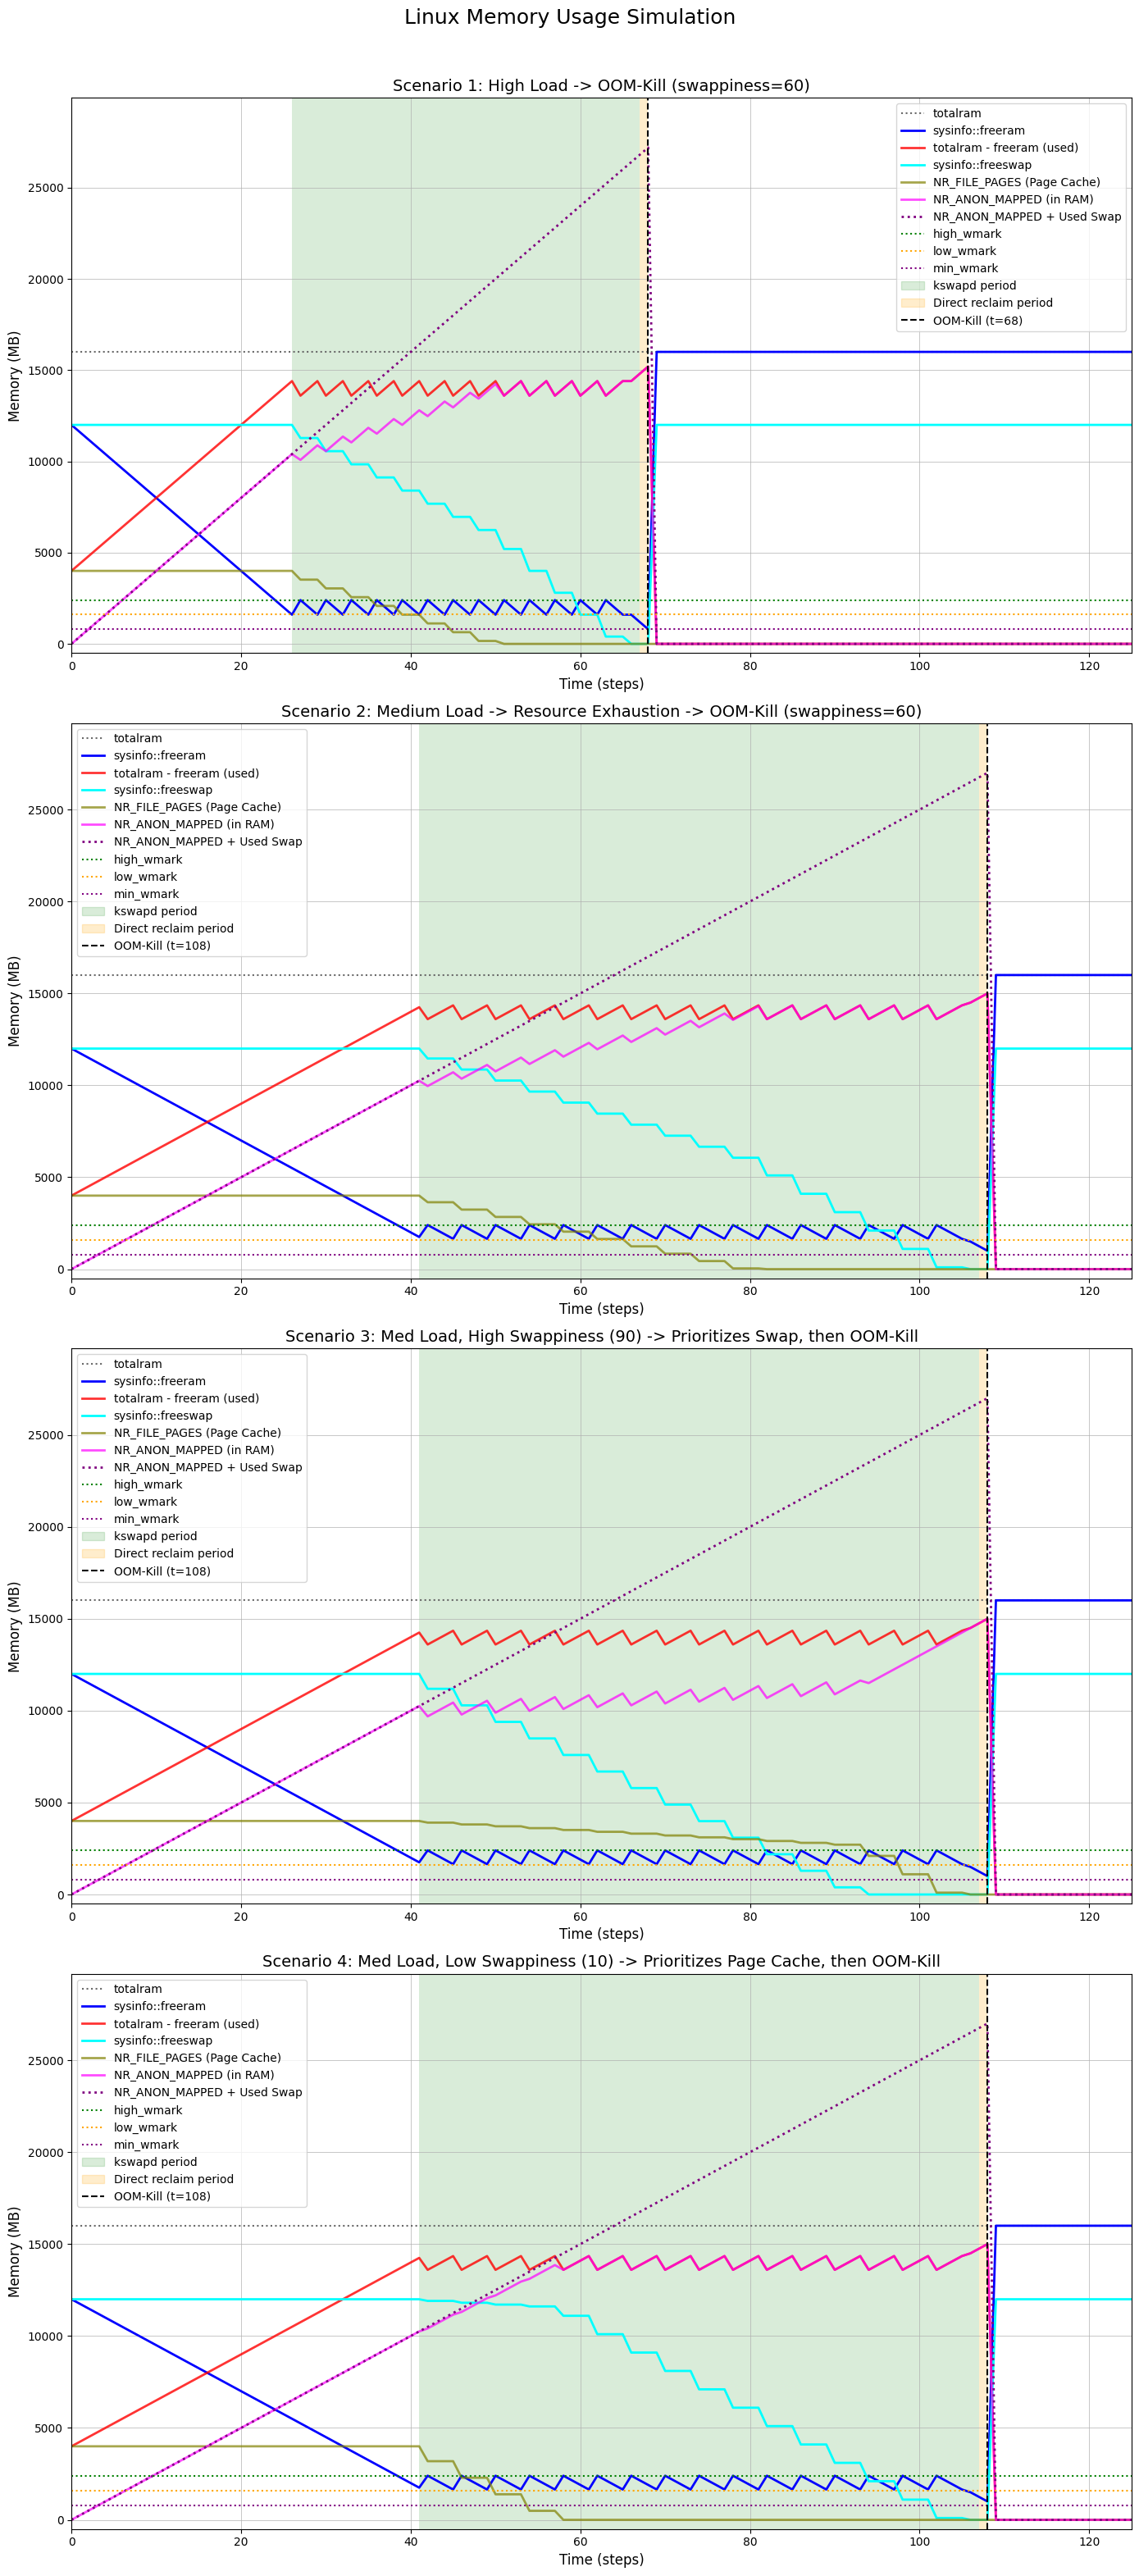

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_with_swappiness(
    total_ram, total_swap, watermarks,
    process_memory_gain, swappiness, initial_file_pages,
    max_steps, stop_step=None
):
    """
    Simulates memory usage considering page cache (NR_FILE_PAGES) and anonymous pages (NR_ANON_MAPPED).
    """
    time = np.arange(max_steps + 1)
    free_ram = np.zeros(max_steps + 1)
    used_ram = np.zeros(max_steps + 1)
    free_swap = np.zeros(max_steps + 1)
    file_pages = np.zeros(max_steps + 1) # NR_FILE_PAGES
    anon_pages_in_ram = np.zeros(max_steps + 1) # NR_ANON_MAPPED (in RAM)
    total_anon_pages = np.zeros(max_steps + 1) # NR_ANON_MAPPED + used_swap
    reclaim_log = np.zeros(max_steps + 1, dtype=int)

    min_wmark = total_ram * watermarks['min']
    low_wmark = total_ram * watermarks['low']
    high_wmark = total_ram * watermarks['high']

    # Initial state
    anon_pages_in_ram[0] = 0
    file_pages[0] = initial_file_pages
    free_ram[0] = total_ram - file_pages[0] - anon_pages_in_ram[0]
    free_swap[0] = total_swap
    used_ram[0] = total_ram - free_ram[0]
    total_anon_pages[0] = anon_pages_in_ram[0] + (total_swap - free_swap[0])

    oom_triggered_time = None

    for t in range(1, max_steps + 1):
        if oom_triggered_time is not None:
            # Maintain state after OOM kill
            free_ram[t], used_ram[t], free_swap[t], file_pages[t], anon_pages_in_ram[t], reclaim_log[t], total_anon_pages[t] = \
                free_ram[t-1], used_ram[t-1], free_swap[t-1], file_pages[t-1], anon_pages_in_ram[t-1], 0, total_anon_pages[t-1]
            continue

        # 1. Memory acquisition (increase in anonymous pages)
        gain = process_memory_gain if not (stop_step and t > stop_step) else 0
        ram_after_gain = free_ram[t-1] - gain

        current_free_swap = free_swap[t-1]
        current_file_pages = file_pages[t-1]
        current_total_anon = total_anon_pages[t-1] + gain

        reclaimed_from_file = 0
        swapped_out = 0

        # 2. Determine the required reclaim level based on the current pressure
        if ram_after_gain < min_wmark:
            tentative_reclaim_log = 2 # Direct reclaim
        elif ram_after_gain < low_wmark:
            tentative_reclaim_log = 1 # kswapd / background reclaim
        else:
            tentative_reclaim_log = 0 # No reclaim

        # 3. Reclaim pages based on swappiness
        if tentative_reclaim_log > 0:
            total_reclaim_needed = high_wmark - ram_after_gain

            swap_tendency = swappiness / 100.0
            file_tendency = 1 - swap_tendency

            swap_target = total_reclaim_needed * swap_tendency
            file_target = total_reclaim_needed * file_tendency

            reclaimed_from_file = min(current_file_pages, file_target)
            swapped_out = min(current_free_swap, swap_target)

            remaining_needed = total_reclaim_needed - (reclaimed_from_file + swapped_out)
            if remaining_needed > 0:
                reclaimed_from_file += min(current_file_pages - reclaimed_from_file, remaining_needed)

            remaining_needed = total_reclaim_needed - (reclaimed_from_file + swapped_out)
            if remaining_needed > 0:
                swapped_out += min(current_free_swap - swapped_out, remaining_needed)

        total_reclaimed_ram = reclaimed_from_file + swapped_out
        ram_after_reclaim_attempt = max(0, ram_after_gain) + total_reclaimed_ram

        # 4. OOM-Kill check (Corrected Logic)
        if ram_after_reclaim_attempt < min_wmark:
            oom_triggered_time = t - 1
            reclaim_log[t-1] = 2

            free_ram[t] = min(free_ram[t-1] + anon_pages_in_ram[t-1], total_ram)
            anon_pages_in_ram[t] = 0
            total_anon_pages[t] = 0
            file_pages[t] = file_pages[t-1]
            free_swap[t] = total_swap
            used_ram[t] = total_ram - free_ram[t]
            reclaim_log[t] = 0
            continue

        # 5. Update state if OOM did not occur
        reclaim_log[t] = tentative_reclaim_log
        free_ram[t] = min(ram_after_reclaim_attempt, total_ram)
        used_ram[t] = total_ram - free_ram[t]
        free_swap[t] = current_free_swap - swapped_out
        file_pages[t] = current_file_pages - reclaimed_from_file
        total_anon_pages[t] = current_total_anon
        anon_pages_in_ram[t] = total_anon_pages[t] - (total_swap - free_swap[t])


    events = {'oom_kill': oom_triggered_time, 'stop_step': stop_step}
    return time, free_ram, used_ram, free_swap, file_pages, anon_pages_in_ram, total_anon_pages, events, reclaim_log

def plot_with_swappiness(ax, data, title, params):
    """Plots the simulation results"""
    time, free_ram, used_ram, free_swap, file_pages, anon_pages_in_ram, total_anon_pages, events, reclaim_log = data
    total_ram, total_swap, watermarks, max_steps = params['total_ram'], params['total_swap'], params['watermarks'], params['max_steps']
    high_wmark = total_ram * watermarks['high']

    ax.axhline(y=total_ram, color='dimgray', linestyle=':', label='totalram')

    ax.plot(time, free_ram, label='sysinfo::freeram', color='blue', linewidth=2)
    ax.plot(time, used_ram, label='totalram - freeram (used)', color='red', linewidth=2, alpha=0.8)
    ax.plot(time, free_swap, label='sysinfo::freeswap', color='cyan', linewidth=2)
    ax.plot(time, file_pages, label='NR_FILE_PAGES (Page Cache)', color='olive', linewidth=2, linestyle='-', alpha=0.7)
    ax.plot(time, anon_pages_in_ram, label='NR_ANON_MAPPED (in RAM)', color='magenta', linewidth=2, linestyle='-', alpha=0.7)
    ax.plot(time, total_anon_pages, label='NR_ANON_MAPPED + Used Swap', color='purple', linewidth=2, linestyle=':')

    ax.axhline(y=high_wmark, color='green', linestyle=':', label='high_wmark')
    ax.axhline(y=total_ram * watermarks['low'], color='orange', linestyle=':', label='low_wmark')
    ax.axhline(y=total_ram * watermarks['min'], color='purple', linestyle=':', label='min_wmark')

    y_max = max(total_ram, np.max(total_anon_pages))
    y_limit_top = y_max * 1.1
    ax.set_ylim(-500, y_limit_top)

    # --- FIX START: Replace fill_between with axvspan for precise period shading ---
    # This logic only affects the plot, not the simulation data.
    # It fills single-step gaps where reclaim stops but memory is still under pressure.
    plot_reclaim_log = reclaim_log.copy()
    for i in range(1, len(plot_reclaim_log)):
        if plot_reclaim_log[i] == 0 and plot_reclaim_log[i-1] > 0 and free_ram[i] < high_wmark:
             plot_reclaim_log[i] = plot_reclaim_log[i-1]

    # Use dummy plots for the legend handles, as axvspan doesn't create them.
    ax.fill_between([], [], color='green', alpha=0.15, label='kswapd period')
    ax.fill_between([], [], color='orange', alpha=0.2, label='Direct reclaim period')

    # Iterate through time and draw a span for each step in a reclaim period.
    # This correctly shades the interval [t-1, t] for an event at step t.
    for t in range(1, max_steps + 1):
        if plot_reclaim_log[t] == 1:
            ax.axvspan(t - 1, t, facecolor='green', alpha=0.15, ec='none')
        elif plot_reclaim_log[t] == 2:
            ax.axvspan(t - 1, t, facecolor='orange', alpha=0.2, ec='none')
    # --- FIX END ---

    if events.get('oom_kill') is not None:
        ax.axvline(x=events['oom_kill'], color='black', linestyle='--', label=f'OOM-Kill (t={events["oom_kill"]})')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Time (steps)', fontsize=12)
    ax.set_ylabel('Memory (MB)', fontsize=12)

    ax.set_xlim(0, max_steps)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)

# --- Parameters ---
BASE_PARAMS = {
    'total_ram': 16000, 'max_steps': 125, 'total_swap': 12000,
    'watermarks': {'min': 0.05, 'low': 0.10, 'high': 0.15},
    'initial_file_pages': 4000
}

# --- Plotting ---
plt.rcParams['font.family'] = 'sans-serif'

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 32))
fig.suptitle('Linux Memory Usage Simulation', fontsize=18)

# --- Scenario Execution & Plotting ---
# Scenario 1: High load -> OOM-Kill
params1 = {**BASE_PARAMS, 'process_memory_gain': 400, 'swappiness': 60}
data1 = simulate_with_swappiness(**params1)
plot_with_swappiness(ax1, data1, 'Scenario 1: High Load -> OOM-Kill (swappiness=60)', params1)

# Scenario 2: Medium load -> Resource exhaustion -> OOM-Kill
params2 = {**BASE_PARAMS, 'process_memory_gain': 250, 'swappiness': 60}
data2 = simulate_with_swappiness(**params2)
plot_with_swappiness(ax2, data2, 'Scenario 2: Medium Load -> Resource Exhaustion -> OOM-Kill (swappiness=60)', params2)

# Scenario 3: Medium load, high swappiness -> Prioritizes Swap, then OOM-Kill
params3 = {**BASE_PARAMS, 'process_memory_gain': 250, 'swappiness': 90}
data3 = simulate_with_swappiness(**params3)
plot_with_swappiness(ax3, data3, 'Scenario 3: Med Load, High Swappiness (90) -> Prioritizes Swap, then OOM-Kill', params3)

# Scenario 4: Medium load, low swappiness -> Prioritizes Page Cache, then OOM-Kill
params4 = {**BASE_PARAMS, 'process_memory_gain': 250, 'swappiness': 10}
data4 = simulate_with_swappiness(**params4)
plot_with_swappiness(ax4, data4, 'Scenario 4: Med Load, Low Swappiness (10) -> Prioritizes Page Cache, then OOM-Kill', params4)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("memory_simulation_en.png")
plt.show()